## Setting Up

In [ ]:
from IPython.display import clear_output

for i in range(100):
    clear_output()

In [ ]:
import pyodbc
import sqlalchemy as sqla

In [ ]:
# Connect via Windows authentication:
# conn_specs = ('DRIVER={ODBC Driver 17 for SQL Server};'
#                                     + 'SERVER=scotty-test;'
#                                     + 'DATABASE=Interject_Reporting;'
#                                    + 'trusted_connection=yes;')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(conn_specs)
# engine = sqla.create_engine(conn_str)

# Define a function that we can use to connect to a db on the fly:
def pyodbc_connect_scotty_test(db_name):
    try:
        connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                                        + 'SERVER=scotty-test;'
                                        + 'DATABASE=' + db_name + ';'
                                       + 'trusted_connection=yes;')
        return connection
    except:
        return 1 # could not connect

In [ ]:
# Find out how many cursors we can have running concurrently:
connection.getinfo(pyodbc.SQL_MAX_CONCURRENT_ACTIVITIES)

In [ ]:
import pandas as pd

In [ ]:
# Connect to [Interject_Reporting]:
# intj_reporting_df = pd.read_sql('[DataCells].[Request]', engine)

reporting_conn = pyodbc_connect_scotty_test('Interject_Reporting')

In [ ]:
# Create a cursor to run straight SQL queries:
reporting_cursor = reporting_conn.cursor()

In [ ]:
# Load [DataCells].[Request] and [DataCells].[Request_History] into DataFrames:
request = 'SELECT * FROM [DataCells].[Request]'
request_history = 'SELECT * FROM [DataCells].[Request_History]'
request_df = pd.read_sql(request, reporting_conn) # So we don't need SQLalchemy...
request_history_df = pd.read_sql(request_history, reporting_conn) # So we don't need SQLalchemy...

## Visualizing DurationSeconds

[DataCells].[DurationSeconds] includes negative values for some reason... their absolute values are accurate, but just have a - in front of them...

In [93]:
request_df['DurationSeconds'].describe()

count    281.000000
mean       5.039146
std       60.829051
min      -10.000000
25%       -2.000000
50%       -1.000000
75%        0.000000
max      984.000000
Name: DurationSeconds, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x04F9FC70>]],
      dtype=object)

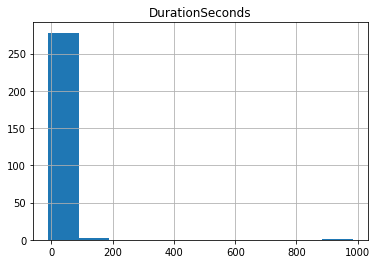

In [94]:
# Histogram of DurationSeconds:
request_df.hist(column='DurationSeconds')

## Request time durations (StartTimeStamp - EndTimeStamp) for Request and Request_History tables

Create a pd series that is ( StartTimeStamp - EndTimeStamp ). Doing this to resolve the negative DurationSeconds values reported above...

#### Setting Up

In [79]:
# Define a function that we can use with both [DataCells].[Request] and .[Request_History]
def get_request_time_durations(table_name):
    start_end_diff_sql = 'SELECT datediff(second, [StartTimeStamp], [EndTimeStamp]) as StartEndDiffSeconds FROM [DataCells].[' + table_name + ']'
    return( pd.read_sql(start_end_diff_sql, reporting_conn) )

In [90]:
request_durations = get_request_time_durations('Request')
request_history_durations = get_request_time_durations('Request_History')

In [81]:
# # Do it with a cursor:
# reporting_cursor.execute(start_end_diff_sql)
# request_durations = pd.Series(reporting_cursor.fetchall())

# # Same thing but with read_sql() instead of cursor:
# request_durations = pd.read_sql(start_end_diff_sql, reporting_conn)

#### Get some initial counts

In [82]:
request_durations.count()

StartEndDiffSeconds    281
dtype: int64

In [91]:
request_history_durations.count()

StartEndDiffSeconds    7417
dtype: int64

In [83]:
request_durations.isna().sum()

StartEndDiffSeconds    60
dtype: int64

In [92]:
request_history_durations.isna().sum()

StartEndDiffSeconds    67
dtype: int64

#### Describe as DF

In [84]:
request_durations.describe()

,StartEndDiffSeconds
count,281.000000
mean,7.825623
std,60.532059
min,0.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,984.000000


In [97]:
request_history_durations.describe()

,StartEndDiffSeconds
count,7.417000e+03
mean,3.146081e+02
std,2.532012e+04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,2.178484e+06


#### Plot query run time distributions

Find unique values and their frequencies, plot the distributions.

In [85]:
request_durations.shape

(341, 1)

In [86]:
request_durations.T.shape

(1, 341)

In [96]:
# 1D-ify them (should become series'):
request_durations_series = request_durations.squeeze()
request_history_durations_series = request_history_durations.squeeze()
print(request_durations_series.shape)
print(request_history_durations_series.shape)

type(request_durations_series) is pd.Series

# Didn't work...
# request_durations_arr = request_durations.values
# request_durations_arr.shape
# request_durations_series = pd.Series(request_durations_arr)

(341,)
(7484,)


True

In [105]:
# Save unique values:
request_unique_times = request_durations_series.unique()
request_history_unique_times = request_history_durations_series.unique()

print('[Request] unique time values: ')
print(request_unique_times)
print('\n[Request_History] unique time values: ')
print(request_history_unique_times)

[Request] unique time values: 
[  0.  12.  13.   9.   8.   1.   5.  11.  31.  27. 187. 180.  nan  24.
 984.  20.   2.   3.   4.   7.   6.]

[Request_History] unique time values: 
[0.000000e+00 1.000000e+00 4.000000e+00 3.000000e+00 4.600000e+01
 2.000000e+00 5.000000e+00          nan 8.000000e+00 6.000000e+00
 7.000000e+00 1.800000e+01 1.700000e+01 6.200000e+01 7.200000e+01
 1.100000e+01 1.980000e+02 2.000000e+01 1.600000e+01 1.900000e+01
 2.300000e+01 9.485300e+04 4.920000e+02 1.500000e+01 1.400000e+01
 1.200000e+01 9.000000e+00 4.000000e+01 2.200000e+01 2.100000e+01
 1.028400e+04 1.067300e+04 1.057100e+04 7.866000e+03 6.110000e+02
 6.090000e+02 6.390000e+02 6.520000e+02 2.400000e+01 3.130000e+02
 2.700000e+01 2.900000e+01 2.500000e+01 6.300000e+01 6.000000e+01
 1.720000e+02 6.100000e+01 6.600000e+01 6.400000e+01 3.660000e+02
 3.600000e+02 1.850000e+02 1.840000e+02 1.210000e+02 7.100000e+01
 7.600000e+01 7.800000e+01 7.700000e+01 7.500000e+01 1.450000e+02
 6.800000e+01 7.900000e+01 9.

In [76]:
type(time_freq) is pd.DataFrame

True

In [111]:
request_time_freq = request_durations_series.value_counts(dropna=False)
request_time_freq

1.0      95
NaN      60
0.0      54
3.0      29
2.0      22
5.0      19
4.0      15
9.0      15
6.0       7
8.0       5
7.0       4
12.0      4
11.0      2
24.0      2
13.0      2
180.0     1
27.0      1
31.0      1
984.0     1
20.0      1
187.0     1
Name: StartEndDiffSeconds, dtype: int64

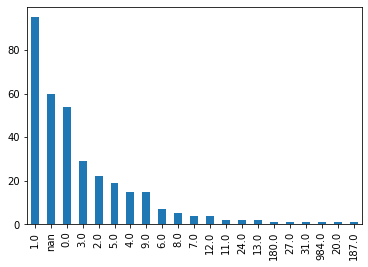

In [113]:
request_time_freq.plot.bar()

In [107]:
request_time_freq = request_history_durations_series.value_counts(dropna=False)
request_time_freq

0.0          4964
1.0          1976
5.0           134
NaN            67
2.0            49
             ... 
389.0           1
2094.0          1
2178484.0       1
652.0           1
611.0           1
Name: StartEndDiffSeconds, Length: 93, dtype: int64

In [122]:
import matplotlib.pyplot as plt

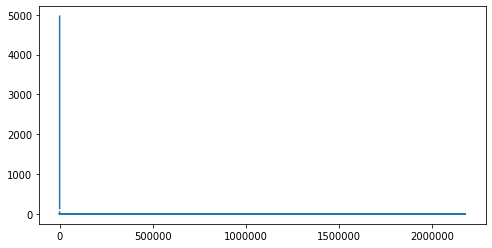

In [133]:
fig = plt.figure(figsize=(8,4))
plt.plot(request_history_time_freq)
plt.show()

# request_history_time_freq.plot.pie()

In [ ]:
fig, ax = plt.subplot()